In [1]:
import numpy as np
np.random.seed(1)

import os
import os.path
import glob

from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm

import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras.applications.xception import Xception,preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "ImagesByFamily"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475
Processing images ...
Images processed: 10868


In [4]:
X.shape

(10868, 224, 224, 3)

In [5]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
filename = 'Microsoft-xceptionfeatures-avgpool.npy'
if os.path.exists(filename):
    print("Loading Xception extracted features from %s ..." %(filename))
    xceptionfeatures = np.load(filename)
else:
    print("Extracting features from Xception layers ...")
    xceptionfeatures = base_model.predict(X)
    print("Saving Xception extracted features into %s ..." %(filename))
    np.save(filename, xceptionfeatures)

Loading Xception extracted features from Microsoft-xceptionfeatures-avgpool.npy ...


In [7]:
xceptionfeatures.shape

(10868, 2048)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [9]:
# Training top_model and saving min training loss weights
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = xceptionfeatures[train_indices]
    y_train = y[train_indices]
    X_test = xceptionfeatures[test_indices]
    y_test = y[test_indices]
    
    top_model = svm.SVC()
    top_model.fit(X_train,y_train)  # Training
    y_pred = top_model.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.9121
[1] Test acurracy: 0.9138
[2] Test acurracy: 0.9145
[3] Test acurracy: 0.9108
[4] Test acurracy: 0.9154
[5] Test acurracy: 0.9088
[6] Test acurracy: 0.9144
[7] Test acurracy: 0.9134
[8] Test acurracy: 0.9206
[9] Test acurracy: 0.9187


In [10]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9142


In [11]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


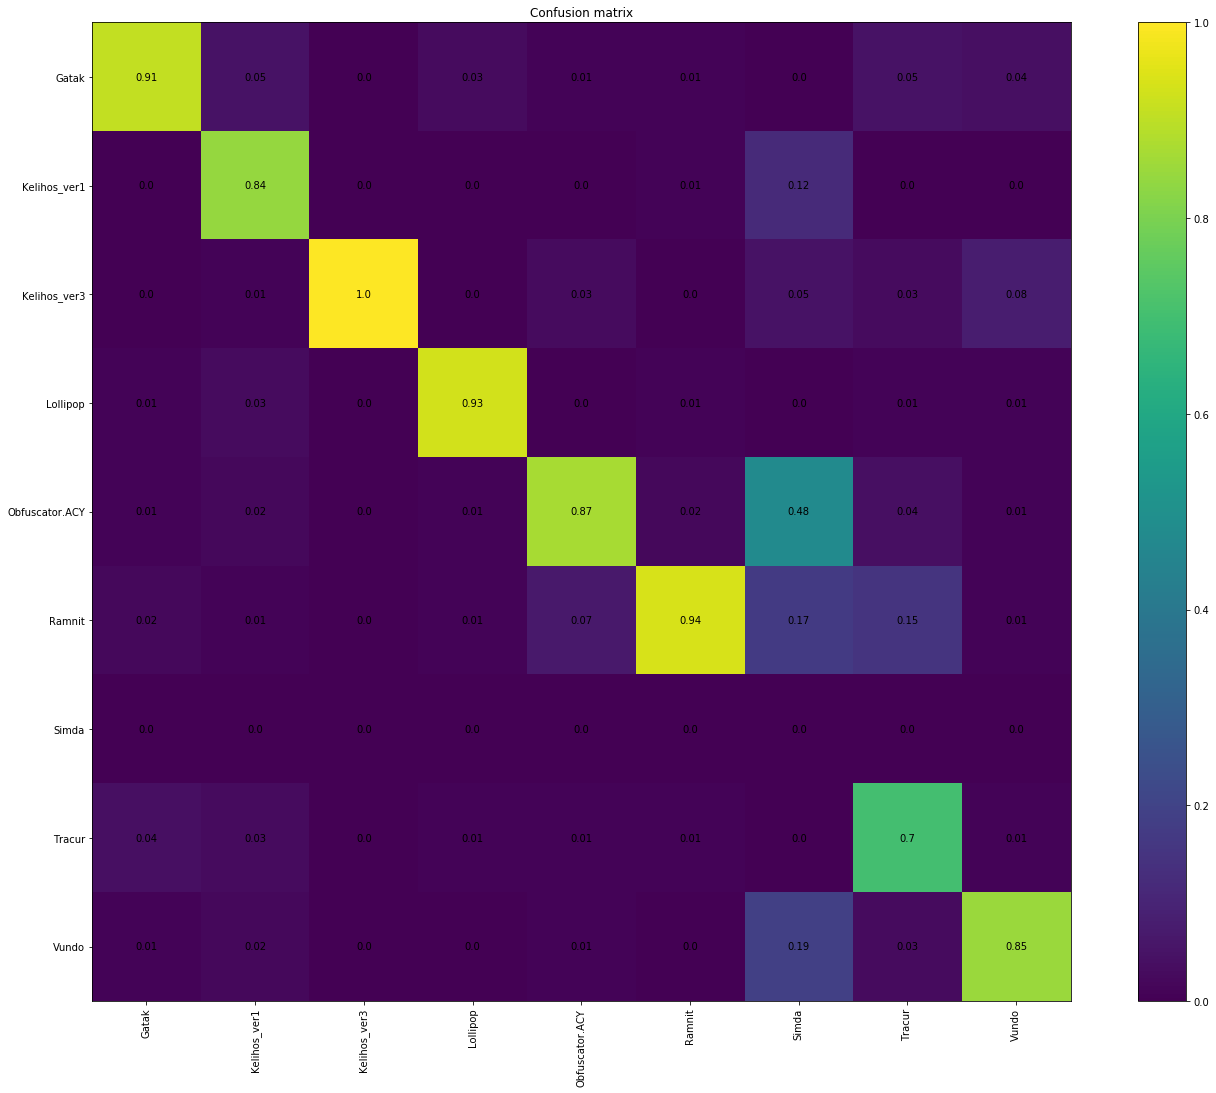

In [12]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()